In [5]:
import torch
from mobilevit import MobileViT

model = MobileViT(arch='x_small', last_channels=1024, gd_conv=True)
state_dict = torch.load(
    'models/x_small_model_weights_best.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
# load validation set
with open('test/validation.txt') as f:
    lines = f.readlines()

images = [line.rstrip('\n') for line in lines]

# sort images based on their labels
sorted_images = sorted(images, key=lambda s : (int(s[:3]), s[8]))

labels = [(int(img[:3])-1) * 2 + int(img[8] == 'r') for img in sorted_images]

In [7]:
import os
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PalmValidationDataset(Dataset):
    def __init__(self, img_dir: str, img_list: list, transform=None):
        super(PalmValidationDataset, self).__init__()
        self.img_dir = img_dir
        self.images = img_list
        # self.labels = label_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.img_dir, img_file)
        image = Image.open(img_path)
        # label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image


/Users/yunchilu/miniconda3/envs/504/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yunchilu/miniconda3/envs/504/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/yunchilu/miniconda3/envs/504/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <EEA9DBAE-D739-32BF-BF5C-B495A4B0502E> /Users/yunchilu/miniconda3/envs/504/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = PalmValidationDataset(img_dir='/root/autodl-tmp/verification/ROI',
                                img_list=sorted_images,
                                transform=transform)

bs = 400
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=12)

feat_mat = torch.zeros(1600, 1024)  # (num_img, dim_feat)

for idx, image in enumerate(dataloader):
    image = image
    with torch.no_grad():
        features = model(image)
        # features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        norm_feat = (features**2).sum(axis=1, keepdim=True).sqrt()
        features = features / norm_feat
        feat_mat[idx * bs : (idx + 1) * bs, :] = features


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yunchilu/miniconda3/envs/504/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/yunchilu/miniconda3/envs/504/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'PalmValidationDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yunchilu/miniconda3/envs/504/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/yunchilu/miniconda3/envs/504/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'PalmValidationDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, 

RuntimeError: DataLoader worker (pid(s) 59873) exited unexpectedly

In [6]:
feat_mat

tensor([[ 0.0272,  0.0096,  0.0099,  ..., -0.0086, -0.0570,  0.0197],
        [ 0.0330,  0.0115,  0.0243,  ...,  0.0038, -0.0563,  0.0196],
        [ 0.0277,  0.0161,  0.0257,  ...,  0.0039, -0.0501,  0.0145],
        ...,
        [ 0.0070,  0.0041, -0.0419,  ...,  0.0099,  0.0096, -0.0227],
        [ 0.0008,  0.0025, -0.0386,  ...,  0.0139,  0.0045, -0.0230],
        [ 0.0085,  0.0012, -0.0294,  ...,  0.0191, -0.0134, -0.0120]],
       device='cuda:0')

In [7]:
# simlilarity matrix
sim_mat = feat_mat @ feat_mat.T

In [8]:
sim_mat

tensor([[ 1.0000,  0.9268,  0.9236,  ..., -0.1083,  0.1184,  0.0372],
        [ 0.9268,  1.0000,  0.9815,  ..., -0.1143,  0.1026,  0.0333],
        [ 0.9236,  0.9815,  1.0000,  ..., -0.1133,  0.0860,  0.0159],
        ...,
        [-0.1083, -0.1143, -0.1133,  ...,  1.0000,  0.4973,  0.4796],
        [ 0.1184,  0.1026,  0.0860,  ...,  0.4973,  1.0000,  0.6940],
        [ 0.0372,  0.0333,  0.0159,  ...,  0.4796,  0.6940,  1.0000]],
       device='cuda:0')

In [9]:
# ground truth matrix
gt = torch.zeros(1600, 1600, dtype=int).cuda()
for i in range(40):
    gt[i * 40 : (i + 1) * 40, i * 40 : (i + 1) * 40] = 1

In [10]:
gt

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')

In [12]:
def test_threshold(sim_mat, gt, img_per_id, step=0.01, t_min=0, t_max=1):
    acc_list = []
    far_list = []    # false acceptance rate
    tpr_list = []    # true positive rate
    
    num_img = gt.shape[0]
    num_id = num_img / img_per_id

    t = t_min    # threshold
    eer = 0  # equal error rate
    min_diff = 1
    while t < t_max:
        predict = sim_mat > t
        correct = predict == gt
        num_true_positive = (predict * gt).sum()
        num_false_positive = (predict * (1 - gt)).sum()
        acc = correct.sum() / (num_img * num_img)
        tpr = (num_true_positive - num_img) / (img_per_id * num_img - num_img)
        far = num_false_positive / (num_img * num_img - img_per_id * img_per_id * num_id)
        if abs(1 - tpr - far) < min_diff:
            eer = (far + 1 - tpr) / 2
            min_diff = abs(1 - tpr - far)
        print(f't = {t:.3f}, acc = {acc:.4f}, tpr = {tpr:.4f}, far = {far:.5f}')
        acc_list.append(acc)
        far_list.append(far)
        tpr_list.append(tpr)
        t += step
    return eer

In [13]:
# If we view left and right hands as different identity
eer = test_threshold(sim_mat, gt, 40, step=0.001, t_max=0.5)
print(f'EER = {eer: .5f}')

t = 0.000, acc = 0.4896, tpr = 0.9981, far = 0.52348
t = 0.001, acc = 0.4940, tpr = 0.9981, far = 0.51889
t = 0.002, acc = 0.4987, tpr = 0.9981, far = 0.51415
t = 0.003, acc = 0.5033, tpr = 0.9981, far = 0.50941
t = 0.004, acc = 0.5078, tpr = 0.9981, far = 0.50476
t = 0.005, acc = 0.5123, tpr = 0.9980, far = 0.50020
t = 0.006, acc = 0.5169, tpr = 0.9980, far = 0.49545
t = 0.007, acc = 0.5214, tpr = 0.9980, far = 0.49086
t = 0.008, acc = 0.5260, tpr = 0.9980, far = 0.48615
t = 0.009, acc = 0.5304, tpr = 0.9979, far = 0.48155
t = 0.010, acc = 0.5349, tpr = 0.9979, far = 0.47694
t = 0.011, acc = 0.5394, tpr = 0.9979, far = 0.47238
t = 0.012, acc = 0.5439, tpr = 0.9979, far = 0.46779
t = 0.013, acc = 0.5483, tpr = 0.9979, far = 0.46327
t = 0.014, acc = 0.5527, tpr = 0.9979, far = 0.45874
t = 0.015, acc = 0.5571, tpr = 0.9978, far = 0.45422
t = 0.016, acc = 0.5615, tpr = 0.9977, far = 0.44970
t = 0.017, acc = 0.5659, tpr = 0.9977, far = 0.44512
t = 0.018, acc = 0.5705, tpr = 0.9976, far = 0

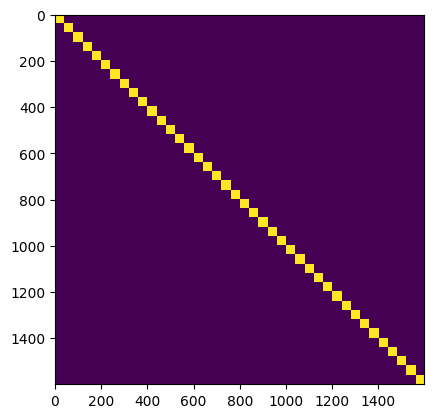

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(gt.cpu().numpy(), cmap='viridis', interpolation='nearest')

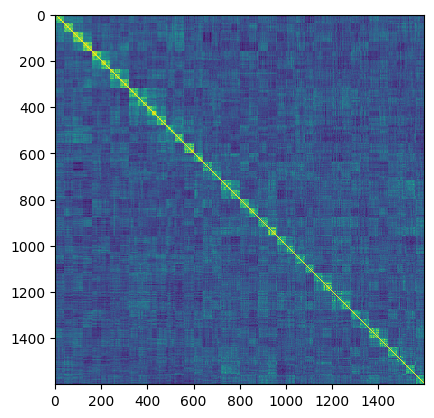

In [16]:
plt.imshow(sim_mat.cpu().numpy(), cmap='viridis', interpolation='nearest')

In [17]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
             Swish-3         [-1, 16, 128, 128]               0
        ConvModule-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           1,024
       BatchNorm2d-6         [-1, 64, 128, 128]             128
             Swish-7         [-1, 64, 128, 128]               0
        ConvModule-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]             576
      BatchNorm2d-10         [-1, 64, 128, 128]             128
            Swish-11         [-1, 64, 128, 128]               0
       ConvModule-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           2,048
      BatchNorm2d-14         [-1, 32, 1